# Analysis of Melbourne Housing Prices
- In this kernel, I analyze the real estate market in Melbourne, Australia.
    - Housing data available at https://www.kaggle.com/anthonypino/melbourne-housing-market#Melbourne_housing_FULL.csv
    - Income data available at https://data.gov.au/dataset/taxation-statistics-2015-16/resource/05e4e3a3-ff92-4a4c-8112-c656dfa8d095
    - Geographic data available at http://services.land.vic.gov.au/SpatialDatamart/

In [1]:
# Dataframes
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

# Modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# Load housing data, drop irrelevant columns, missing price observations
melb = pd.read_csv('Melbourne_Housing.csv')
melb = melb.drop(columns=['Address', 'SellerG', 'Date' ,'CouncilArea', 'Suburb',
                          'Lattitude' ,'Longtitude' ,'Regionname', 'Method'])
melb = melb.dropna(subset=['Price'])

In [3]:
# Load tax data, keep relevant columns, make per-capita statistics
taxes = pd.read_csv('taxstats2016individual06btaxablestatusstateterritorypostcodetaxableincome.csv')
VOI = ['Postcode','Number of individuals\nno.','Total Income or Loss \n$']
taxes = taxes[VOI]
taxes.columns = ['Postcode', 'Working Population', 'Income']
taxes['Income per Capita'] = taxes['Income'] / taxes['Working Population']
taxes = taxes.drop(columns = ['Income'])

In [4]:
# Fix Postcode variable and merge with housing data
taxes.Postcode = pd.to_numeric(taxes.Postcode, errors='coerce')
taxes = taxes.dropna(subset=['Postcode'])
melb = pd.merge(left=melb, right=taxes, on='Postcode', how='inner')

In [5]:
# Info on listing level data set
melb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27246 entries, 0 to 27245
Data columns (total 14 columns):
Rooms                 27246 non-null int64
Type                  27246 non-null object
Price                 27246 non-null float64
Distance              27246 non-null float64
Postcode              27246 non-null float64
Bedroom2              20806 non-null float64
Bathroom              20800 non-null float64
Car                   20423 non-null float64
Landsize              17982 non-null float64
BuildingArea          10656 non-null float64
YearBuilt             12084 non-null float64
Propertycount         27244 non-null float64
Working Population    27246 non-null int64
Income per Capita     27246 non-null float64
dtypes: float64(11), int64(2), object(1)
memory usage: 3.1+ MB


In [6]:
# Summary Statistics
summary = melb.describe().transpose()[['count', 'mean', 'std', 'min', 'max']]
summary = summary.drop(['Postcode'])
summary

,count,mean,std,min,max
Rooms,27246.000,2.992,0.955,1.000,16.000
Price,27246.000,1050189.280,641473.509,85000.000,11200000.000
Distance,27246.000,11.280,6.787,0.000,48.100
Bedroom2,20806.000,3.046,0.955,0.000,20.000
Bathroom,20800.000,1.592,0.701,0.000,9.000
Car,20423.000,1.715,0.994,0.000,18.000
Landsize,17982.000,593.489,3757.266,0.000,433014.000
BuildingArea,10656.000,156.835,449.223,0.000,44515.000
YearBuilt,12084.000,1966.609,36.762,1196.000,2019.000
Propertycount,27244.000,7566.781,4492.382,83.000,21650.000


In [7]:
# Make Latex table of summary statistics
print(summary.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     count &        mean &        std &       min &          max \\
\midrule
Rooms              & 27246.000 &       2.992 &      0.955 &     1.000 &       16.000 \\
Price              & 27246.000 & 1050189.280 & 641473.509 & 85000.000 & 11200000.000 \\
Distance           & 27246.000 &      11.280 &      6.787 &     0.000 &       48.100 \\
Bedroom2           & 20806.000 &       3.046 &      0.955 &     0.000 &       20.000 \\
Bathroom           & 20800.000 &       1.592 &      0.701 &     0.000 &        9.000 \\
Car                & 20423.000 &       1.715 &      0.994 &     0.000 &       18.000 \\
Landsize           & 17982.000 &     593.489 &   3757.266 &     0.000 &   433014.000 \\
BuildingArea       & 10656.000 &     156.835 &    449.223 &     0.000 &    44515.000 \\
YearBuilt          & 12084.000 &    1966.609 &     36.762 &  1196.000 &     2019.000 \\
Propertycount      & 27244.000 &    7566.781 &   4492.382 &    83.000 &    21650.000 \\
Workin

In [8]:
# Price correlations
corrs = melb.corr()
corrs['Price'].sort_values(ascending=False).drop('Postcode')

Price                 1.000
Rooms                 0.465
Income per Capita     0.443
Bedroom2              0.430
Bathroom              0.430
Car                   0.202
BuildingArea          0.101
Landsize              0.033
Propertycount        -0.059
Working Population   -0.172
Distance             -0.211
YearBuilt            -0.333
Name: Price, dtype: float64

In [9]:
# Make Latex table of price correlations
print(corrs['Price'].sort_values(ascending=False).drop('Postcode').to_latex())

\begin{tabular}{lr}
\toprule
{} &  Price \\
\midrule
Price              &  1.000 \\
Rooms              &  0.465 \\
Income per Capita  &  0.443 \\
Bedroom2           &  0.430 \\
Bathroom           &  0.430 \\
Car                &  0.202 \\
BuildingArea       &  0.101 \\
Landsize           &  0.033 \\
Propertycount      & -0.059 \\
Working Population & -0.172 \\
Distance           & -0.211 \\
YearBuilt          & -0.333 \\
\bottomrule
\end{tabular}



In [10]:
# Make Postcode-level variables
hoods = melb.drop(columns = ['Type'])
hoods = hoods.groupby('Postcode').mean()

In [11]:
# Drop variables with lots of missing values for postcode level data
drop = ['Landsize', 'BuildingArea', 'YearBuilt', 'Distance']
for i in drop: del hoods[i]
hoods = hoods.dropna()
hoods.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 208 entries, 3000.0 to 3978.0
Data columns (total 8 columns):
Rooms                 208 non-null float64
Price                 208 non-null float64
Bedroom2              208 non-null float64
Bathroom              208 non-null float64
Car                   208 non-null float64
Propertycount         208 non-null float64
Working Population    208 non-null float64
Income per Capita     208 non-null float64
dtypes: float64(8)
memory usage: 14.6 KB


In [12]:
# Scale postcode-level variables to have 0 mean and unit variance
# This ensures that variable scale does not affect clusters
scaler = StandardScaler()
scaler.fit(hoods)
scaled_hoods = scaler.transform(hoods)

In [13]:
# Cluster neighborhoods into four groups
# Note: this is a randomized algorithm and may have slightly different results than in the paper
kmeans = KMeans(n_clusters=4)
kmeans.fit(scaled_hoods)
hoods['Cluster'] = kmeans.labels_

In [14]:
# Import shapefile and keep relevant variables
shapes = geopandas.read_file('postcodes/postcode_polygon.shp')
shapes.POSTCODE = pd.to_numeric(shapes.POSTCODE, errors='coerce')
shapes.columns = [i.lower() for i in list(shapes.columns)]
shapes = shapes[['postcode','geometry']]

In [15]:
# Keep relevant variables from each postcode
hoods = hoods.reset_index()
hoods = hoods[['Postcode', 'Income per Capita', 'Working Population', 'Price', 'Cluster']]
hoods.columns = [i.lower() for i in list(hoods.columns)]

In [16]:
# Merge postcode data to geographic data
shapes = pd.merge(left = shapes, right = hoods, on ='postcode', how = 'left')
shapes = geopandas.GeoDataFrame(shapes, geometry='geometry')

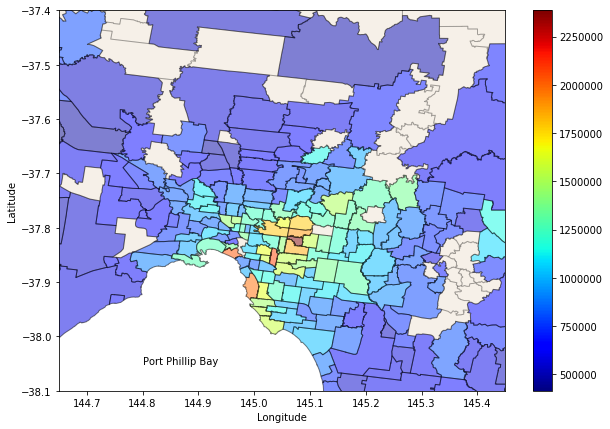

In [17]:
# Map of average prices by postcode
fig, gax = plt.subplots(figsize=(10,7))
shapes[shapes.price>=0].plot(ax=gax, edgecolor='black', alpha=0.5,
           column="price", cmap=plt.get_cmap("jet"), legend=True)
shapes[~(shapes.price>=0)].plot(ax=gax, edgecolor='black', color='tan', alpha=0.2)
gax.annotate('Port Phillip Bay', xy=(144.8, -38.05))
gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
plt.xlim([144.65,145.45])
plt.ylim([-38.1,-37.4])
# plt.savefig('prices.pdf', bbox_inches='tight')
plt.show()

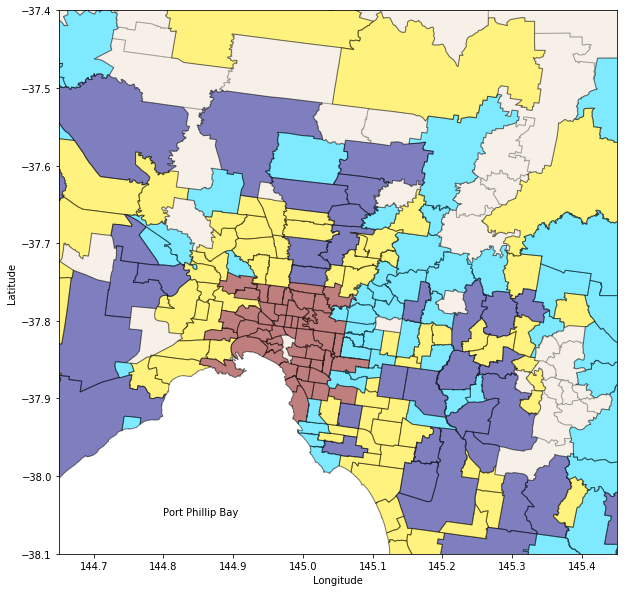

In [18]:
# Map of K-means Clustered Postcodes
fig, gax = plt.subplots(figsize=(10,10))
shapes[shapes.price>=0].plot(ax=gax, edgecolor='black', alpha=0.5,
           column="cluster", cmap=plt.get_cmap("jet"))
shapes[~(shapes.price>=0)].plot(ax=gax, edgecolor='black', color='tan', alpha=0.2)
gax.annotate('Port Phillip Bay', xy=(144.8, -38.05))
gax.set_xlabel('Longitude')
gax.set_ylabel('Latitude')
plt.xlim([144.65,145.45])
plt.ylim([-38.1,-37.4])
# plt.savefig('clusters.pdf', bbox_inches='tight')
plt.show()

In [19]:
# Turn type into hot-one encoded dummies, drop NA values
melb = pd.concat([melb,pd.get_dummies(melb['Type'], prefix='Type',dummy_na=False)],axis=1).drop(['Type'],axis=1)
melb = melb.drop(columns=['Postcode'])
melb = melb.dropna()

In [20]:
# Train/test split
train_set, test_set = train_test_split(melb, test_size=0.2, random_state=21)

In [21]:
# Split train/test sets into labels and predictor matrices
cols = [col for col in melb.columns if col != 'Price']
y_train, X_train = train_set['Price'], train_set[cols]
y_test, X_test = test_set['Price'], test_set[cols]

In [22]:
# Train a linear regression
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
# Assess performance of linear regression
r_2 = reg.score(X_test, y_test)
mse = ((reg.predict(X_test)-y_test)**2).mean()
print('The Linear Regression has an MSE of %0.4f on the test set.' %mse)
print('The Linear Regression has an R-squared value of %0.4f on the test set.' %r_2)

The Linear Regression has an MSE of 148399804233.8285 on the test set.
The Linear Regression has an R-squared value of 0.6482 on the test set.


In [24]:
# Scale training features to be standard normal
scaler = StandardScaler()
scaler.fit(X_train)
sX_train = scaler.transform(X_train)
sX_test = scaler.transform(X_test)

In [25]:
# Train a lasso regression
lasso = linear_model.LassoCV(cv=10)
lasso = lasso.fit(sX_train, y_train)

In [26]:
# Assess performance of lasso regression
r_2 = lasso.score(sX_test, y_test)
mse = ((lasso.predict(sX_test)-y_test)**2).mean()
print('The Lasso Regression has an MSE of %0.4f on the test set.' %mse)
print('The Lasso Regression has an R-squared value of %0.4f on the test set.' %r_2)

The Lasso Regression has an MSE of 148354208486.6617 on the test set.
The Lasso Regression has an R-squared value of 0.6483 on the test set.


In [27]:
# Test 10-fold CV error of KNN for each parameter in grid
# Retain best estimator object
param_grid = [
    {'n_neighbors': list(range(5, 30, 5))},
]
knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(sX_train, y_train)
knn = grid_search.best_estimator_
print(grid_search.best_params_)

{'n_neighbors': 10}


In [28]:
# Assess performance of KNN regression
r_2 = knn.score(sX_test, y_test)
mse = ((knn.predict(sX_test)-y_test)**2).mean()
print('The KNN Regression has an MSE of %0.4f on the test set.' %mse)
print('The KNN Regression has an R-squared value of %0.4f on the test set.' %r_2)

The KNN Regression has an MSE of 120237538823.3069 on the test set.
The KNN Regression has an R-squared value of 0.7150 on the test set.


In [29]:
# Test 10-fold CV error of Random Forest for each parameter in grid
# Retain best estimator object
param_grid = [
    {'n_estimators': [16, 32, 64, 128], 'max_features': [2, 4, 6, 8, 10]},
]
forest = RandomForestRegressor()
grid_search = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(X_train, y_train)
forest = grid_search.best_estimator_
print(grid_search.best_params_)

{'max_features': 6, 'n_estimators': 128}


In [30]:
# Assess performance of random forest
# Note: this is a randomized algorithm and may have slightly different results than in the paper
r_2 = forest.score(X_test, y_test)
mse = ((forest.predict(X_test)-y_test)**2).mean()
mad = (abs((forest.predict(X_test)-y_test))).mean()
print('The Random Forest has an MSE of %0.4f on the test set.' %mse)
print('The Random Forest has an R-squared value of %0.4f on the test set.' %r_2)
print('The Random Forest has an MAD of %0.4f on the test set' %mad)

The Random Forest has an MSE of 77477207074.2263 on the test set.
The Random Forest has an R-squared value of 0.8163 on the test set.
The Random Forest has an MAD of 162178.1486 on the test set


In [31]:
# Generate variable importances for random forest
imps = pd.DataFrame(forest.feature_importances_,
                    index = X_train.columns,
                    columns=['importance']).sort_values('importance', ascending=False)
imps

,importance
Income per Capita,0.274
BuildingArea,0.257
YearBuilt,0.091
Distance,0.071
Landsize,0.064
Rooms,0.055
Bathroom,0.039
Bedroom2,0.036
Working Population,0.028
Type_h,0.027


In [32]:
# Make Latex table of variable importances
print(imps.to_latex())

\begin{tabular}{lr}
\toprule
{} &  importance \\
\midrule
Income per Capita  &       0.274 \\
BuildingArea       &       0.257 \\
YearBuilt          &       0.091 \\
Distance           &       0.071 \\
Landsize           &       0.064 \\
Rooms              &       0.055 \\
Bathroom           &       0.039 \\
Bedroom2           &       0.036 \\
Working Population &       0.028 \\
Type\_h             &       0.027 \\
Propertycount      &       0.024 \\
Type\_u             &       0.020 \\
Car                &       0.014 \\
Type\_t             &       0.001 \\
\bottomrule
\end{tabular}

